# Hands On NLP Preprocessing: Step-by-Step Guide

This notebook demonstrates various Natural Language Processing (NLP) preprocessing techniques applied to a legal dataset. NLP preprocessing is essential for converting raw text data into a format that can be effectively analyzed by machine learning algorithms.

The notebook covers:
- Text exploration and basic statistics
- Tokenization of text into words
- Removal of stopwords
- Stemming and lemmatization
- Part-of-speech tagging
- Text cleaning and normalization


## 1. Import Required Libraries

First, we need to import the necessary Python libraries for NLP preprocessing:

In [17]:
# Import necessary libraries

import nltk

# Download required NLTK data packages
nltk.download('punkt_tab')        # For tokenization
nltk.download('stopwords')    # For stopword removal
nltk.download('wordnet')      # For lemmatization
nltk.download('averaged_perceptron_tagger_eng')  # For POS tagging

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
'''
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from nltk import pos_tag, ne_chunk

from collections import Counter
from wordcloud import WordCloud  # You may need to install this: pip install wordcloud

# Download required NLTK resources
print("Downloading required NLTK resources...")

nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)
print("Downloads complete.")

'''


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


'\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\nimport re\nfrom nltk import pos_tag, ne_chunk\n\nfrom collections import Counter\nfrom wordcloud import WordCloud  # You may need to install this: pip install wordcloud\n\n# Download required NLTK resources\nprint("Downloading required NLTK resources...")\n\nnltk.download(\'maxent_ne_chunker\', quiet=True)\nnltk.download(\'words\', quiet=True)\nprint("Downloads complete.")\n\n'

## 2. Load and Explore the Dataset

Now we'll load the legal dataset from a CSV file and explore its basic properties:

In [4]:
# Load the dataset
import pandas as pd
print("Loading the legal dataset...")
df = pd.read_csv('legal_dataset.csv')

# Display basic information
print(f"\nDataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nBasic information about the dataset:")
df.info()

print("\nSummary statistics:")
display(df.describe(include='all'))

Loading the legal dataset...

Dataset shape: (24, 4)

First 5 rows:


,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...



Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24 non-null     object
 1   case_outcome  24 non-null     object
 2   case_title    24 non-null     object
 3   case_text     24 non-null     object
dtypes: object(4)
memory usage: 900.0+ bytes

Summary statistics:


,case_id,case_outcome,case_title,case_text
count,24,24,24,24
unique,24,4,24,20
top,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
freq,1,14,1,2



Checking for missing values:
case_id           0
case_outcome      0
case_title        0
case_text         0
text_length       0
word_count        0
sentence_count    0
dtype: int64

Working with text column: 'case_id'

Text statistics:
Average text length: 5.62 characters
Average word count: 1.00 words
Average sentence count: 1.00 sentences


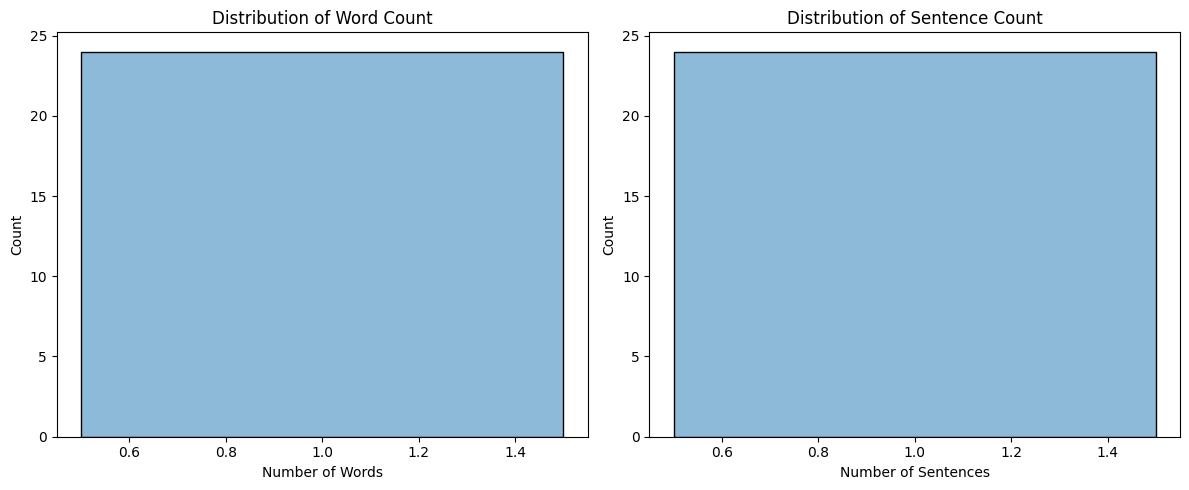

In [6]:
# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# Choose the text column to preprocess (first column)
text_col = df.columns[0]
print(f"\nWorking with text column: '{text_col}'")

# Display text length statistics
df['text_length'] = df[text_col].astype(str).apply(len)
df['word_count'] = df[text_col].astype(str).apply(lambda x: len(x.split()))
df['sentence_count'] = df[text_col].astype(str).apply(lambda x: len(sent_tokenize(str(x))))

print("\nText statistics:")
print(f"Average text length: {df['text_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Average sentence count: {df['sentence_count'].mean():.2f} sentences")

# Visualize text length distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')
plt.subplot(1, 2, 2)
sns.histplot(df['sentence_count'], kde=True)
plt.title('Distribution of Sentence Count')
plt.xlabel('Number of Sentences')
plt.tight_layout()
plt.show()

## 3. Text Cleaning

Before tokenization, we'll clean the text by:
- Converting to lowercase
- Removing special characters and digits
- Removing extra whitespace

In [7]:
# Function to clean text
def clean_text(text):
    # Convert to string in case there are non-string entries
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['cleaned_text'] = df[text_col].apply(clean_text)

# Show cleaning example
print("Text cleaning example:")
example_idx = 0  # Using the first document as an example
original = df[text_col].iloc[example_idx]
cleaned = df['cleaned_text'].iloc[example_idx]

# Display the first 200 characters of each for comparison
print(f"\nOriginal text (first 200 chars):\n{original[:200]}...")
print(f"\nCleaned text (first 200 chars):\n{cleaned[:200]}...")

Text cleaning example:

Original text (first 200 chars):
Case1...

Cleaned text (first 200 chars):
case...


## 4. Tokenization

Tokenization breaks text into smaller units such as sentences or words. We'll use NLTK's word_tokenize and sent_tokenize functions:

Tokenization example:

First 15 word tokens: ['case']

Sentences: ['Case1']


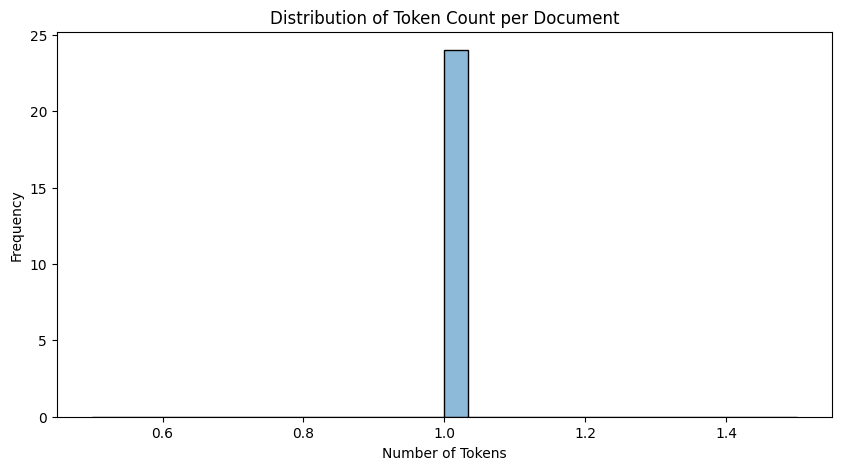

In [8]:
# Word tokenization
df['tokenized'] = df['cleaned_text'].apply(word_tokenize)

# Sentence tokenization
df['sentences'] = df[text_col].astype(str).apply(sent_tokenize)

# Show tokenization example
print("Tokenization example:")
example_idx = 0  # Using the first document as an example

# Display first 15 tokens
tokens = df['tokenized'].iloc[example_idx]
print(f"\nFirst 15 word tokens: {tokens[:15]}")

# Display first 2 sentences (if available)
sentences = df['sentences'].iloc[example_idx]
if len(sentences) >= 2:
    print(f"\nFirst 2 sentences:")
    for i, sent in enumerate(sentences[:2]):
        print(f"{i+1}. {sent}")
else:
    print(f"\nSentences: {sentences}")

# Create a histogram of token counts
token_counts = df['tokenized'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(token_counts, kde=True, bins=30)
plt.title('Distribution of Token Count per Document')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

## 5. Stopword Removal

Stopwords are common words (like "the", "a", "an", "in") that don't carry much meaning in NLP analysis. We'll remove them using NLTK's stopwords list:

In [9]:
# Get English stopwords
stop_words = set(stopwords.words('english'))
print(f"Number of stopwords: {len(stop_words)}")
print(f"Sample stopwords: {list(stop_words)[:10]}")

# Remove stopwords and non-alphanumeric tokens
df['no_stopwords'] = df['tokenized'].apply(
    lambda words: [w for w in words if w.lower() not in stop_words and w.isalnum()]
)

# Show stopwords removal example
example_idx = 0  # Using the first document
original_tokens = df['tokenized'].iloc[example_idx]
filtered_tokens = df['no_stopwords'].iloc[example_idx]

print("\nStopword removal example:")
print(f"Original token count: {len(original_tokens)}")
print(f"After stopword removal: {len(filtered_tokens)}")
print(f"\nFirst 15 original tokens: {original_tokens[:15]}")
print(f"First 15 filtered tokens: {filtered_tokens[:15]}")

# Calculate stopword percentage
original_counts = df['tokenized'].apply(len)
filtered_counts = df['no_stopwords'].apply(len)
percent_removed = ((original_counts - filtered_counts) / original_counts * 100).mean()

print(f"\nOn average, {percent_removed:.2f}% of tokens were removed as stopwords")

Number of stopwords: 198
Sample stopwords: ['nor', 'your', 'under', 'what', "that'll", "don't", 'this', 'further', 'we', "we'd"]

Stopword removal example:
Original token count: 1
After stopword removal: 1

First 15 original tokens: ['case']
First 15 filtered tokens: ['case']

On average, 0.00% of tokens were removed as stopwords


## 6. Stemming

Stemming reduces words to their root form (stem) by removing affixes. For example, "running", "runs", and "ran" all become "run". We'll use the Porter Stemmer algorithm:

In [10]:
# Initialize Porter Stemmer
stemmer = PorterStemmer()

# Apply stemming to the filtered tokens
df['stemmed'] = df['no_stopwords'].apply(lambda words: [stemmer.stem(w) for w in words])

# Show stemming examples
example_idx = 0
filtered_tokens = df['no_stopwords'].iloc[example_idx]
stemmed_tokens = df['stemmed'].iloc[example_idx]

print("Stemming examples:")
print(f"\nFirst 15 tokens before stemming: {filtered_tokens[:15]}")
print(f"First 15 tokens after stemming: {stemmed_tokens[:15]}")

# Display some interesting examples of stemming
print("\nSpecific stemming examples:")
examples = ["running", "runs", "ran", "easily", "fairly", "wolves", "better", "was", "mice"]
for word in examples:
    print(f"{word} → {stemmer.stem(word)}")

# Show stemming results in a DataFrame for the first few tokens
stem_comparison = pd.DataFrame({
    'Original': filtered_tokens[:10],
    'Stemmed': stemmed_tokens[:10]
})
display(stem_comparison)

Stemming examples:

First 15 tokens before stemming: ['case']
First 15 tokens after stemming: ['case']

Specific stemming examples:
running → run
runs → run
ran → ran
easily → easili
fairly → fairli
wolves → wolv
better → better
was → wa
mice → mice


,Original,Stemmed
0,case,case


## 7. Lemmatization

Lemmatization is similar to stemming but produces actual dictionary words. It's more sophisticated but slower than stemming. For example, "better" becomes "good" rather than "better" or "bet":

In [11]:
# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the filtered tokens
df['lemmatized'] = df['no_stopwords'].apply(lambda words: [lemmatizer.lemmatize(w) for w in words])

# Show lemmatization examples
example_idx = 0
filtered_tokens = df['no_stopwords'].iloc[example_idx]
lemmatized_tokens = df['lemmatized'].iloc[example_idx]

print("Lemmatization examples:")
print(f"\nFirst 15 tokens before lemmatization: {filtered_tokens[:15]}")
print(f"First 15 tokens after lemmatization: {lemmatized_tokens[:15]}")

# Display some interesting examples of lemmatization
print("\nSpecific lemmatization examples:")
examples = ["better", "worse", "running", "mice", "wolves", "are", "feet", "children", "companies"]
for word in examples:
    print(f"{word} → {lemmatizer.lemmatize(word)}")

# Compare stemming and lemmatization side by side
comparison = []
for word in examples:
    comparison.append({
        'Original': word,
        'Stemmed': stemmer.stem(word),
        'Lemmatized': lemmatizer.lemmatize(word)
    })

comparison_df = pd.DataFrame(comparison)
display(comparison_df)

Lemmatization examples:

First 15 tokens before lemmatization: ['case']
First 15 tokens after lemmatization: ['case']

Specific lemmatization examples:
better → better
worse → worse
running → running
mice → mouse
wolves → wolf
are → are
feet → foot
children → child
companies → company


,Original,Stemmed,Lemmatized
0,better,better,better
1,worse,wors,worse
2,running,run,running
3,mice,mice,mouse
4,wolves,wolv,wolf
5,are,are,are
6,feet,feet,foot
7,children,children,child
8,companies,compani,company


## 8. Part-of-Speech Tagging

POS tagging identifies the grammatical parts of speech of each word (noun, verb, adjective, etc.). This can be helpful for lemmatization and for understanding the structure of sentences:

In [14]:
# Apply POS tagging to the filtered tokens
df['pos_tags'] = df['no_stopwords'].apply(pos_tag)

# Show POS tagging examples
example_idx = 0
pos_tagged = df['pos_tags'].iloc[example_idx]

print("Part-of-Speech tagging example:")
print("\nFirst 15 tokens with POS tags:")
for i, (word, tag) in enumerate(pos_tagged[:15]):
    print(f"{i+1}. {word} → {tag}")

# Explain common POS tags
pos_tag_explanations = {
    'CC': 'Coordinating conjunction',
    'CD': 'Cardinal number',
    'DT': 'Determiner',
    'IN': 'Preposition or subordinating conjunction',
    'JJ': 'Adjective',
    'JJR': 'Adjective, comparative',
    'JJS': 'Adjective, superlative',
    'NN': 'Noun, singular or mass',
    'NNP': 'Proper noun, singular',
    'NNPS': 'Proper noun, plural',
    'NNS': 'Noun, plural',
    'RB': 'Adverb',
    'VB': 'Verb, base form',
    'VBD': 'Verb, past tense',
    'VBG': 'Verb, gerund or present participle',
    'VBN': 'Verb, past participle',
    'VBP': 'Verb, non-3rd person singular present',
    'VBZ': 'Verb, 3rd person singular present'
}

print("\nCommon POS tag explanations:")
for tag, explanation in list(pos_tag_explanations.items())[:10]:
    print(f"{tag}: {explanation}")

# Count frequency of each POS tag
all_tags = [tag for doc_tags in df['pos_tags'] for _, tag in doc_tags]
tag_freq = Counter(all_tags)

# Display the most common POS tags
print("\nMost common POS tags in the dataset:")
for tag, count in tag_freq.most_common(10):
    explanation = pos_tag_explanations.get(tag, "Other")
    print(f"{tag} ({explanation}): {count} occurrences")

Part-of-Speech tagging example:

First 15 tokens with POS tags:
1. case → NN

Common POS tag explanations:
CC: Coordinating conjunction
CD: Cardinal number
DT: Determiner
IN: Preposition or subordinating conjunction
JJ: Adjective
JJR: Adjective, comparative
JJS: Adjective, superlative
NN: Noun, singular or mass
NNP: Proper noun, singular
NNPS: Proper noun, plural

Most common POS tags in the dataset:
NN (Noun, singular or mass): 24 occurrences


## 9. Text Visualization

Visualizing text data can provide insights about the most frequent terms and their relationships. Let's create a word cloud and frequency distribution plot:

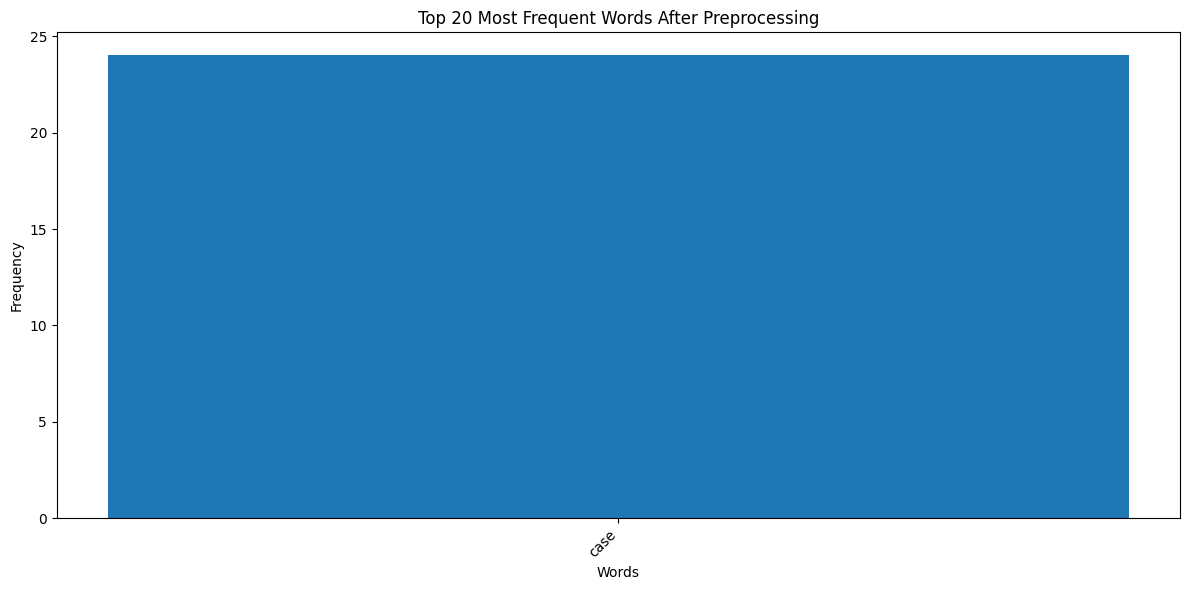

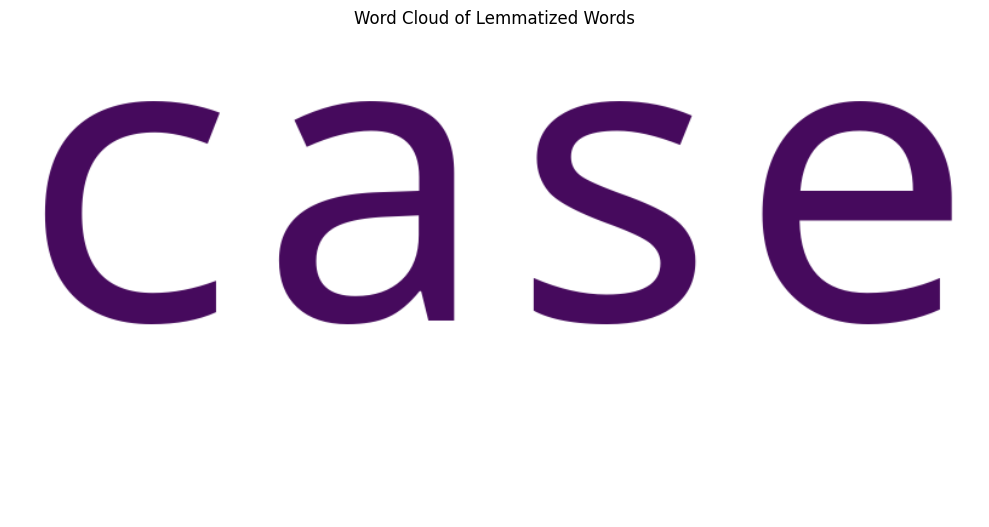

In [15]:
# Get all words from the lemmatized tokens
all_lemmas = [word for doc_lemmas in df['lemmatized'] for word in doc_lemmas]
lemma_freq = Counter(all_lemmas)

# Plot frequency distribution of top words
top_n = 20
top_words = dict(lemma_freq.most_common(top_n))

plt.figure(figsize=(12, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {top_n} Most Frequent Words After Preprocessing')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Generate a word cloud
try:
    # Create a text string for the word cloud
    lemmatized_text = ' '.join(all_lemmas)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=200,
                         contour_width=3,
                         contour_color='steelblue')

    wordcloud.generate(lemmatized_text)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Lemmatized Words')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Couldn't generate word cloud: {e}")
    print("You may need to install the wordcloud package: pip install wordcloud")

## 10. Conclusion

In this notebook, we've covered the essential steps in NLP preprocessing:

1. **Data Exploration**: Understanding the structure and content of our dataset
2. **Text Cleaning**: Removing special characters and normalizing text
3. **Tokenization**: Breaking text into individual words and sentences
4. **Stopword Removal**: Filtering out common words that don't carry much meaning
5. **Stemming**: Reducing words to their word stem
6. **Lemmatization**: Converting words to their base dictionary form
7. **Part-of-Speech Tagging**: Identifying grammatical components
8. **Visualization**: Creating word clouds and frequency plots

These preprocessing steps are fundamental for any NLP task, including:
- Text classification
- Sentiment analysis
- Document clustering
- Topic modeling
- Information retrieval
- And more!

With our processed data, we're now ready to apply various machine learning algorithms for deeper analysis.